I have used the following methods.


* I used an image processing methods for images <span style="color:#e74c3c;"> <b>(contrast limited adaptive histogram equalization (CLAHE)[1])</b> </span>
* <b>Custom convolutional block</b> for A CNN model,
* <b>Custom callback</b> class that used creating the test set classification report during training each 50 epochs[2]
* I used the validation set for testing

## Model
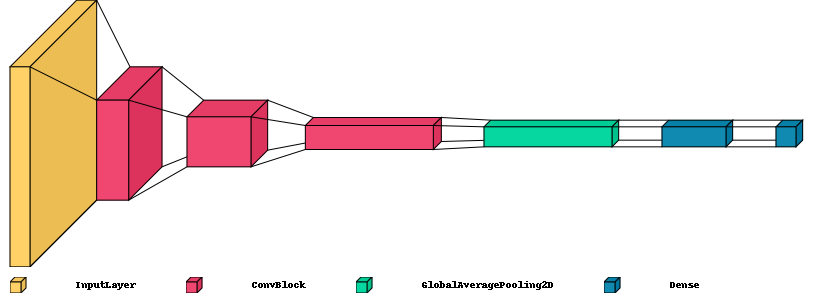

## Example Test Predictions (During Training)
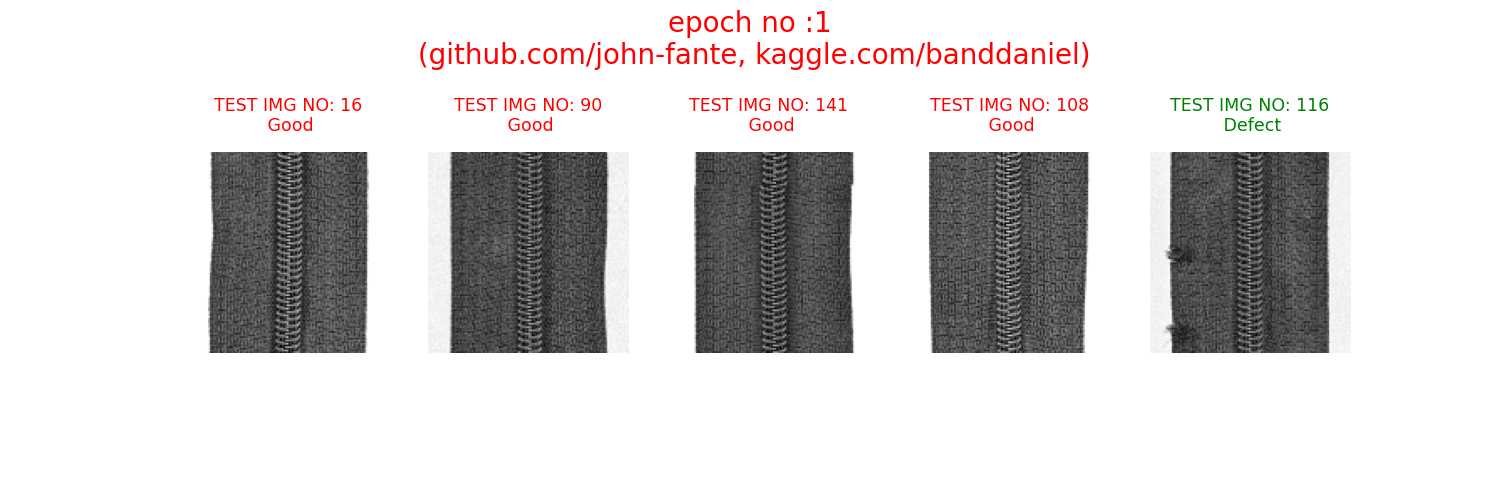
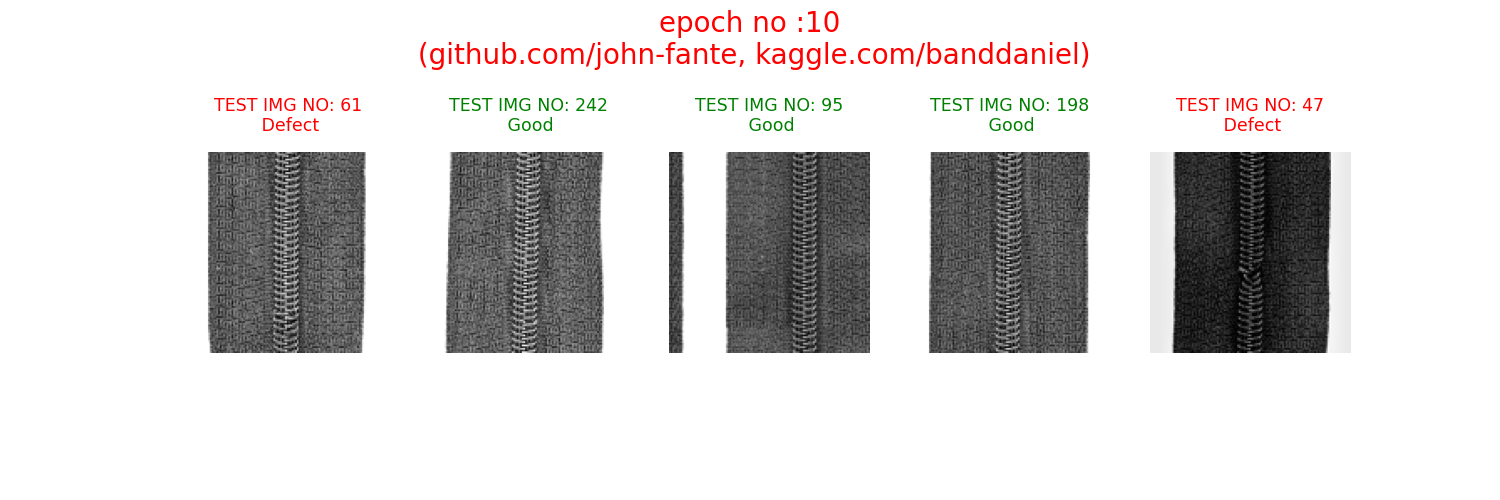

## References
1. https://en.wikipedia.org/wiki/Adaptive_histogram_equalization
2. My another custom callbacks for Tensorflow (https://github.com/john-fante/my-tensorflow-custom-callbacks)


In [ ]:
# Importing dependencies

from IPython.display import clear_output
!pip install visualkeras
clear_output()

In [ ]:
# Importing dependencies

import os 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
import visualkeras
from colorama import Fore, Back, Style

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Layer,Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Activation, BatchNormalization, Flatten


SEED = 10
BATCH_SIZE = 32
IMG_SIZE = 100, 100

In [ ]:
# Creating new folders

os.mkdir(os.path.join('/kaggle/working/',  'train'))
os.mkdir(os.path.join('/kaggle/working/',  'validation'))

os.mkdir(os.path.join('/kaggle/working/train/',  'good'))
os.mkdir(os.path.join('/kaggle/working/train/',  'defect'))

os.mkdir(os.path.join('/kaggle/working/validation/',  'good'))
os.mkdir(os.path.join('/kaggle/working/validation/',  'defect'))

# <span style="color:#e74c3c;"> Image </span> Processing

<span style="color:#16a085;"> <i><b>Contrast Limited Adaptive Histogram Equalization (CLAHE)</b></i>
 </span>

In [ ]:
# A function for creating random samples from good and defect datasets then applies CLAHE operation

def create_random_clahe_training_sample():
    good_sample = np.random.permutation(sorted(os.listdir('/kaggle/input/resized-zipper/train/good')))[0]
    defect_sample = np.random.permutation(sorted(os.listdir('/kaggle/input/resized-zipper/train/defect')))[0]
    
    good_sample_img = '/kaggle/input/resized-zipper/train/good/' + good_sample
    defect_sample_img = '/kaggle/input/resized-zipper/train/defect/' + defect_sample
    
    clahe_op = cv2.createCLAHE(clipLimit= 2 , tileGridSize=(10,10)) # CLAHE function

    good_img = cv2.imread(good_sample_img)
    good_img = cv2.cvtColor(good_img, cv2.COLOR_BGR2GRAY)
    good_final_img = clahe_op.apply(good_img)
    
    defect_img = cv2.imread(defect_sample_img)
    defect_img = cv2.cvtColor(defect_img, cv2.COLOR_BGR2GRAY)
    defect_final_img = clahe_op.apply(defect_img)
    
    fig, ax = plt.subplots(2,2, figsize = (5,5), dpi = 150)
    
    ax[0][0].imshow(good_img, cmap = 'gray')
    ax[0][0].set_title('an original image (GOOD)', fontsize = 8)
    ax[0][0].axis('off')

    ax[0][1].imshow(good_final_img, cmap = 'gray')
    ax[0][1].set_title('after CLAHE operation',  color = 'red', fontsize = 8)
    ax[0][1].axis('off')

    ax[1][0].imshow(defect_img, cmap = 'gray')
    ax[1][0].set_title('an original image (DEFECT)', fontsize = 8)
    ax[1][0].axis('off')

    ax[1][1].imshow(defect_final_img, cmap = 'gray')
    ax[1][1].set_title('after CLAHE operation',  color = 'red', fontsize = 8)
    ax[1][1].axis('off')


In [ ]:
# Creating example samples

create_random_clahe_training_sample()

In [ ]:
# A function for applying image processing operation to all datasets

def image_chale_gray(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :
        img = cv2.imread(os.path.join(main_path, i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe_op = cv2.createCLAHE(clipLimit= 2 , tileGridSize=(10,10))
        img = clahe_op.apply(img)

        cv2.imwrite(os.path.join(target_path, i), img)

In [ ]:
image_chale_gray('/kaggle/input/resized-zipper/train/defect', '/kaggle/working/train/defect')
image_chale_gray('/kaggle/input/resized-zipper/train/good', '/kaggle/working/train/good')

image_chale_gray('/kaggle/input/resized-zipper/validation/defect', '/kaggle/working/validation/defect')
image_chale_gray('/kaggle/input/resized-zipper/validation/good', '/kaggle/working/validation/good')

In [ ]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in tqdm(images, desc = 'images' ):
        full_path.append(os.path.join(path, i))
    return full_path


train_defect = create_images_list('/kaggle/working/train/defect')
train_good = create_images_list('/kaggle/working/train/good')

test_defect = create_images_list('/kaggle/working/validation/defect')
test_good = create_images_list('/kaggle/working/validation/good')


# look-up table
classes = {0:'good', 1 : 'defect'}


train_data = pd.concat([ pd.DataFrame({'img':train_defect, 'label': 1 }),
                         pd.DataFrame({'img':train_good, 'label': 0 }) ])


test_data = pd.concat([ pd.DataFrame({'img':test_defect, 'label': 1 }),
                        pd.DataFrame({'img':test_good, 'label': 0 })])


train_data = shuffle(train_data, random_state = SEED).reset_index(drop = True)
test_data = shuffle(test_data, random_state = SEED).reset_index(drop = True)


In [ ]:
print("train images: ", train_data.shape[0])
print("test images: ", test_data.shape[0])

In [ ]:
# Calculation class weights for training set

counts = np.bincount(train_data['label'])

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [ ]:
# Reading and resizing images
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 1)
    img = tf.image.resize(img, size =  (IMG_SIZE) )
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label


# Basic data augmentation - randomly flips up or down 
def img_augmentation(image, label):
    
    radn_num = np.random.randint(0, 100)
    if radn_num % 2 == 0:
        img = tf.image.random_flip_up_down(image)
        return img, label
    else:
        return image, label

In [ ]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['img'],train_data['label'] ))
train_dataset = (train_loader
                 .map(img_preprocessing)
                 .map(img_augmentation)
                 .shuffle(train_data.shape[0])
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))



test_loader = tf.data.Dataset.from_tensor_slices((test_data['img'],test_data['label'] ))
test_dataset = (test_loader
                .map(img_preprocessing)
                .batch(BATCH_SIZE)
                .prefetch(BATCH_SIZE))
                

# <span style="color:#e74c3c;"> CNN </span> Model


In [ ]:
# Creating a convolution block class

class ConvBlock(Layer):
    def __init__(self, filters, kernel_size, activation = 'relu', batch_norm = False, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.batch_norm = batch_norm
        
        self.conv = Conv2D(filters, kernel_size, strides = 1, padding = 'same')
        self.norm = BatchNormalization()
        self.act = Activation(activation)
        self.pool = MaxPooling2D()

    
    def call(self, inputs):
        X = self.conv(inputs)
        if self.norm:
            X = self.norm(X)
            X = self.act(X)
            X = self.pool(X)
            return X
        else:
            X = self.act(X)
            X = self.pool(X)
            return X
        
    
    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "activation" : self.act}

In [ ]:
# Custom callback for creating a test set classification report during training each 50 epochs

# test_dataset -> test tf.dataset
# target_names -> class names
# pred_round -> using for sigmoid output

class TestClassificationReportDuringTraining(Callback):
    def on_epoch_end(self, epochs, logs = None ):
        
        if (epochs + 1) % 50 == 0:
            test_take1 =  test_dataset.take(-1)
            test_take1_ = list(test_take1)
            pred = model.predict(test_take1)
            pred = np.round(pred).reshape(pred.shape[0])
        
            clf = classification_report(test_data['label'] , pred, target_names = list(classes.values()) )    
    
            print(Fore.RED + '~'*65)
            print(Style.RESET_ALL)
            print(Back.YELLOW + Fore.BLACK +'(Test Classification Report) Epoch no :' + str(epochs + 1))
            print(Style.RESET_ALL)
            print(Style.BRIGHT + clf)
            print(Style.RESET_ALL)
            print(Fore.RED + '~'*65)
            print(Style.RESET_ALL)

        else:
            pass

In [ ]:
inp = Input(shape = (*IMG_SIZE,1))
C = ConvBlock(32, 2, activation = 'elu', batch_norm = True, name = 'CONV_BLOCK_1')(inp)
C = ConvBlock(64, 2, activation = 'elu', batch_norm = True, name = 'CONV_BLOCK_2')(C)
C = ConvBlock(128, 2, activation = 'elu', batch_norm = True, name = 'CONV_BLOCK_3')(C)
C = GlobalAveragePooling2D()(C)
C = Dense(64, activation = 'relu')(C)
out = Dense(1, activation = 'sigmoid')(C)


model = Model(inputs = inp, outputs = out )
model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss ='binary_crossentropy', metrics = ['AUC', 'Precision', 'Recall'])
my_callbacks = [TestClassificationReportDuringTraining()]

model.summary()

In [ ]:
#Plotting the model

plt.figure(dpi = 100)
visualkeras.layered_view(model, spacing = 50,  scale_z = 1, scale_xy = 2 , legend=True, type_ignore=[BatchNormalization, Activation, Dropout])


# <span style="color:#e74c3c;"> Training </span> 


In [ ]:
hist = model.fit(train_dataset, epochs = 130, batch_size = BATCH_SIZE, class_weight=class_weight, callbacks = my_callbacks)

[](http://)

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation


In [ ]:
fig, axs = plt.subplots(1,1, figsize = (5,5), dpi = 100)

axs.grid(linestyle = 'dashdot')
axs.plot(hist.history['auc'])
axs.plot(hist.history['precision'])
axs.plot(hist.history['recall'])
axs.set_xlabel('epochs', fontsize = 10)
axs.legend(['AUC', 'Precision', 'Recall'], fontsize = 10)
axs.set_title('Train Metrics', fontsize = 10)

# <span style="color:#e74c3c;"> Test </span> Prediction, Evaluation


In [ ]:
test_eval = model.evaluate(test_dataset)
print('Test Loss: {0:.3f}'.format(test_eval[0]))
print('Test AUC: {0:.3f}'.format(test_eval[1]))
print('Test Precision: {0:.3f}'.format(test_eval[2]))
print('Test Recall: {0:.3f}'.format(test_eval[3]))

In [ ]:
# Test set prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)
pred = np.round(pred).reshape(pred.shape[0])

# <span style="color:#e74c3c;"> Test </span> Classification Report

In [ ]:
clf = classification_report(test_data['label'] , pred, target_names = list(classes.values()) )
print(clf)

# <span style="color:#e74c3c;"> Test </span> Confusion Matrix

In [ ]:
cm = confusion_matrix(test_data['label']  , pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(5, 5))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)

In [ ]:
# A function that creating one random image in the test set and prediction it

def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (8, 8) ,dpi = 150)
    
    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        
        if label == pred[i]:
            axs[i].imshow(img , cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idxs[i]) + ")" + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img , cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idxs[i]) + ")" + '\n' + classes[label], fontsize = 8, color = 'red')

In [ ]:
random_test_sample_with_prediction()
random_test_sample_with_prediction()